# Chunker

> Create clean and "enriched" chunks

In [ ]:
#| default_exp chunkr

In [ ]:
#| export
import os
import re
import time
from io import BytesIO
from dotenv import load_dotenv
import base64
from fastcore.all import *
from rich import print

import pandas as pd
from mistralai import Mistral
from PIL import Image
# from tqdm import tqdm

from evaluatr.readers import load_evals


In [ ]:
#| export
load_dotenv()
mistral_api_key = os.getenv("MISTRAL_API_KEY")

In [ ]:
#| export
def get_doc_subtype(
    id:str, # ID of the evaluation
    fname:str, # Name of the file
    evals # Evaluations data
    )->str: # Document Subtype
    "Get Document Subtype for a given file in the evaluation dataset"
    eval_data = L(evals).filter(lambda x: x['id']==id)
    if not eval_data: return None
    
    docs = L(eval_data[0]['docs'])
    matches = docs.filter(lambda x: Path(x['File URL']).name==fname)
    return matches[0]['Document Subtype'] if matches else None

Given an evaluation `id` and a `pdf` file name of one of its supporting doc we can check its `subtype`.

For instance, for the "Final Evaluation of the EU-IOM Joint ..." evaluation:

In [ ]:
#| eval: false
fname_json = '../_data/output/evaluations.json'
path_pdf = Path('../_data/pdf_library')

title = 'Final Evaluation of the EU-IOM Joint Initiative for migrant protection and reintegration in the Horn of Africa'
evals = load_evals(fname_json)

results = [o for o in evals.filter(lambda x: title.lower() in x['meta']['Title'].lower())]; results

[{'id': '49d2fba781b6a7c0d94577479636ee6f',
  'docs': [{'Document Subtype': 'Evaluation report',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Abridged%20Evaluation%20Report_%20Final_Olta%20NDOJA.pdf',
    'File description': 'Evaluation Report'},
   {'Document Subtype': 'Evaluation brief',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Evaluation%20Learning%20Brief_Final_Olta%20NDOJA.pdf',
    'File description': 'Evaluation Brief'},
   {'Document Subtype': 'Annexes',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Final%20Evaluation%20Report%20Final_Olta%20NDOJA.pdf',
    'File description': 'Abridged Report'},
   {'Document Subtype': 'Management response',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/HoA%20EU%20JI%20Final%20Eval%20-%20Management%20Response%20Matrix%20-%20Final.pdf',
    'File description': 'Manageme

In [ ]:
#| eval: false
id = '49d2fba781b6a7c0d94577479636ee6f'
for o in path_pdf.ls().filter(lambda x: x.name == id)[0].ls():
    print(f'Name: {o.name}\nSubtype: {get_doc_subtype(id, o.name, evals)}')

Name: Evaluation%20Learning%20Brief_Final_Olta%20NDOJA.pdf
Subtype: Evaluation brief

Name: HoA%20EU%20JI%20Final%20Eval%20-%20Management%20Response%20Matrix%20-%20Final.pdf
Subtype: Management response

Name: Abridged%20Evaluation%20Report_%20Final_Olta%20NDOJA.pdf
Subtype: Evaluation report

Name: Final%20Evaluation%20Report%20Final_Olta%20NDOJA.pdf
Subtype: Annexes

In [ ]:
#| eval: false
# first_paper = df.iloc[0]
# print(first_paper)
# first_paper_pdf = (Path('../_data/zotero/') / first_paper['zot_id']).ls(file_exts='.pdf')[0]; first_paper_pdf

In [ ]:
#| export
src_dir = Path("../_data/")

## Mistral client

In [ ]:
#| export
def ocr_pdf(
    pdf_path:Union[Path,str], # Path to the PDF file to process
    model:str="mistral-ocr-latest", # Model name to use for OCR processing
    include_images:bool=True, # Whether to include base64-encoded images in the response
    api_key:str=mistral_api_key # Mistral API key for authentication
):
    "Upload a PDF file and process it with OCR in one go"
    if isinstance(pdf_path, str): pdf_path = Path(pdf_path)
    cli = Mistral(api_key=api_key)
    
    uploaded_pdf = cli.files.upload(
        file={
            "file_name": pdf_path.stem,
            "content": pdf_path.read_bytes(),
        },
        purpose="ocr"
    )

    signed_url = cli.files.get_signed_url(file_id=uploaded_pdf.id)
    
    return cli.ocr.process(
        model=model,
        document={
            "type": "document_url",
            "document_url": signed_url.url,
        },
        include_image_base64=include_images
    )

In [ ]:
pdf_fname = "https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Abridged%20Evaluation%20Report_%20Final_Olta%20NDOJA.pdf"

In [ ]:
#| eval: false
r = ocr_pdf(first_paper_pdf)

[OCRPageObject(index=0, markdown='# Certified reference material IAEA-418: ${ }^{129}$ I in Mediterranean Sea water \n\nM. K. Pham $\\cdot$ M. Betti $\\cdot$ P. P. Povinec $\\cdot$ V. Alfimov $\\cdot$ D. Biddulph $\\cdot$<br>J. Gastaud $\\cdot$ W. E. Kieser $\\cdot$ J. M. López Gutiérrez $\\cdot$ G. Possnert $\\cdot$<br>J. A. Sanchez-Cabeza $\\cdot$ T. Suzuki\n\nReceived: 7 May 2010/Published online: 25 May 2010\n(c) Akadémiai Kiadó, Budapest, Hungary 2010\n\n\n#### Abstract\n\nA certified reference material designed for the determination of ${ }^{129} \\mathrm{I}$ in seawater, IAEA-418 (Mediterranean Sea water) is described and the results of certification are presented. The median of ${ }^{129} \\mathrm{I}$ concentration with $95 \\%$ confidence interval was chosen as the most reliable estimates of the true value. The median, given as the certified value, is $2.28 \\times 10^{8}$ atom $\\mathrm{L}^{-1}(95 \\%$ confidence interval is $\\left.(2.16-2.73) 10^{8} \\mathrm{atom} \\mathrm{
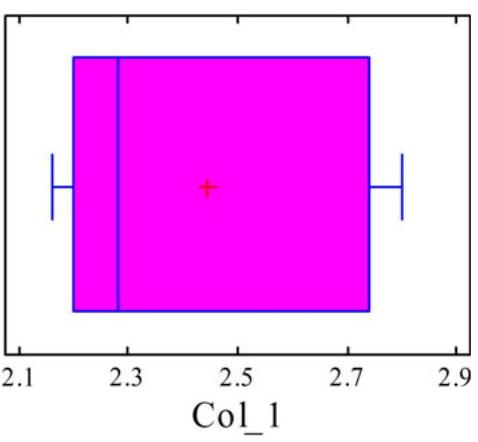
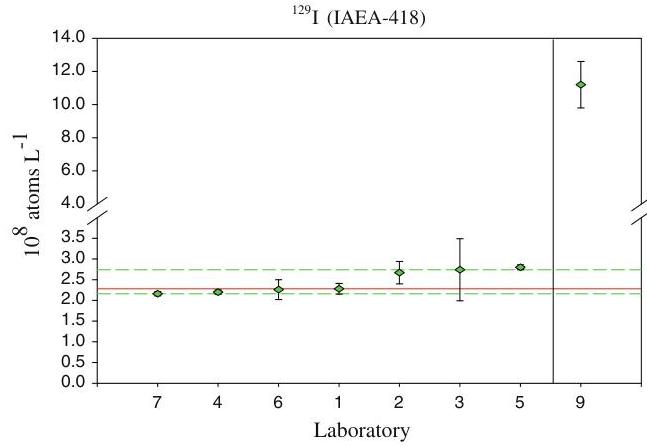
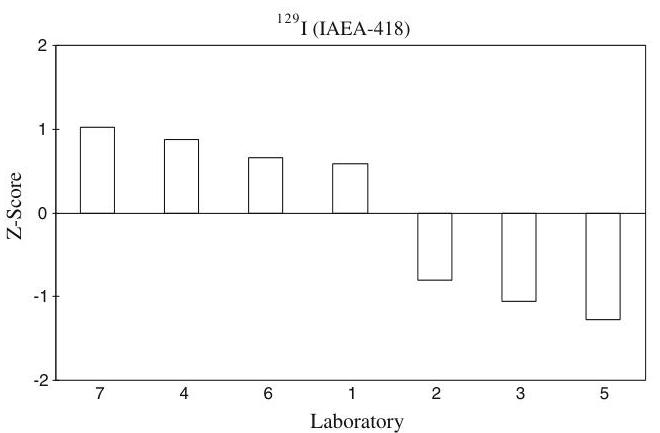

In [ ]:
#| eval: false
r.pages

In [ ]:
#| eval: false
print(r.pages[4].markdown)

Table 2 Certified ${ }^{129} \mathrm{I}$ concentrations in IAEA-418: Mediterranean Sea water (reference date: 18th 
February 2001; half-life of ${ }^{129} \mathrm{I}$ is $(1.57 \pm 0.04) \times 10^{7}$ years)

| Certified values | ${ }^{129} \mathrm{I}$ concentration |  |
| :-- | :-- | :-- |
|  | $\left(10^{8} \mathrm{atom} \mathrm{L}^{-1}\right)$ | $\left(10^{-7} \mathrm{~Bq} \mathrm{~L}^{-1}\right)$ |
| Mean $\pm 2$ Std. dev. | $2.44 \pm 0.27$ | $3.41 \pm 0.37$ |
| Median | 2.28 | 3.19 |
| Confidence interval $(\alpha=0.05)$ | $2.16-2.73$ | $3.02-3.82$ |
| Expanded uncertainty $(k=2)$ | 0.20 | 0.28 |

Evidence on metrological traceability to the SI Units was provided by all laboratories and is summarized in Table 
3.

## $Z$-score analysis

Following the International Union of Pure and Applied Chemistry (IUPAC) [27] and the ISO [28] recommendations for 
assessment of laboratory performance, the Z-score methodology was used for the evaluation of the interlaboratory 
results and performance of the participating laboratories. The Z-score was calculated as following:
$Z=\left(X_{i}-X_{\mathrm{a}}\right) / S_{\mathrm{b}}$,
where $X_{i}$ is the robust mean of activity concentration values reported by laboratory $i, X_{\mathrm{a}}$ is the
assigned value (a mean value of accepted results), and $S_{\mathrm{b}}$ is the target standard deviation. The right
target value depends on the objective of the exercise. For radionuclide analysis, laboratories were required to 
have a relative bias below $20 \%\left(S_{\mathrm{b}}<10 \%\right)$.

The uncertainty of the assigned value $\left(S_{\mathrm{ta}}\right)$ was included in the target value for bias 
[29]:
$\left(X_{i}-X_{\mathrm{a}}\right) / \sqrt{s_{\mathrm{b}}^{2}+s_{\mathrm{ta}}^{2}}$
The performance of a laboratory is considered to be acceptable if the difference between the robust mean of the 
laboratory and the assigned value (in $S_{\mathrm{b}}$ units) is less than or equal to 2 . A $Z$-score from 2 to 3 
indicates that the results are of questionable quality, and the result of analysis is regarded as an outlier when 
$|Z|>3$. The performance of laboratories in terms of accuracy is expressed by $Z$-scores in Fig. 3. The 
distribution of $Z$-scores is symmetric with their values less than 2 , indicating that the overall performance of 
the participating laboratories was satisfactory.

## Degree of equivalence of the reported results

Following the International Committee of Weights and Measures (CIPM) recommendation [30], the degree of equivalence
of reported results was also included in the data evaluation process. It permits to verify if the measurement 
reported is consistent with the key comparison reference value.

To compare the relationship between the reported results and their uncertainties, an estimator $\varepsilon$ (a 
degree of equivalence of a reported results) was calculated by rating the difference between the reported value and
the reference value (median) to the total propagated uncertainty of this difference with a coverage factor of two (
$95 \%$ confidence level):

Table 3 AMS laboratories included in the evaluation and metrological traceability of reported results

| Laboratory | Instrument | Standards and calibrators |
| :--: | :--: | :--: |
| Japan Atomic Energy Agency, Mutsu | AMS-HVEE ${ }^{\mathrm{a}} 3$ MV Tandetron | NIST 4949C |
| University of Sevilla ${ }^{\text {b }}$ | AMS-HVEE ${ }^{\mathrm{a}} 1$ MV Tandetron | NIST 3230 |
| University of Arizona | AMS-NEC ${ }^{\mathrm{c}} 3$ MV Pelletron | AgI standard (prepared by the Purdue 
University, USA) |
| University of Uppsala | AMS-NEC ${ }^{\mathrm{c}} 5$ MV Pelletron | NIST 4949C |
| University of Toronto | AMS-GIC ${ }^{\text {d }} 3$ MV Tandetron (operated at 2 MV for these measurements) | AgI
reference material Iso-2 ${ }^{\text {e }}$ |
| University of Toronto ${ }^{\text {b }}$ | AMS-GIC ${ }^{\text {d }} 3$ MV Tandetron (operated at 2 MV for these 
measurements) | AgI reference material Iso-2 ${

In [ ]:
#| eval: false
from IPython.display import display, Markdown
Markdown(r.pages[0].markdown)

# Certified reference material IAEA-418: ${ }^{129}$ I in Mediterranean Sea water 

M. K. Pham $\cdot$ M. Betti $\cdot$ P. P. Povinec $\cdot$ V. Alfimov $\cdot$ D. Biddulph $\cdot$<br>J. Gastaud $\cdot$ W. E. Kieser $\cdot$ J. M. López Gutiérrez $\cdot$ G. Possnert $\cdot$<br>J. A. Sanchez-Cabeza $\cdot$ T. Suzuki

Received: 7 May 2010/Published online: 25 May 2010
(c) Akadémiai Kiadó, Budapest, Hungary 2010


#### Abstract

A certified reference material designed for the determination of ${ }^{129} \mathrm{I}$ in seawater, IAEA-418 (Mediterranean Sea water) is described and the results of certification are presented. The median of ${ }^{129} \mathrm{I}$ concentration with $95 \%$ confidence interval was chosen as the most reliable estimates of the true value. The median, given as the certified value, is $2.28 \times 10^{8}$ atom $\mathrm{L}^{-1}(95 \%$ confidence interval is $\left.(2.16-2.73) 10^{8} \mathrm{atom} \mathrm{L}^{-1}\right)$, or $3.19 \times 10^{-7} \mathrm{~Bq} \mathrm{~L}^{-1}(95 \%$ confidence interval is $\left.(3.02-3.82) \times 10^{-7} \mathrm{~Bq} \mathrm{~L}^{-1}\right)$. The material is intended to be used for standardization procedures applied in accelerator mass spectrometric laboratories. It is available in 1 L units and may be ordered via IAEA web side (www.iaea.org).


[^0]Keywords ${ }^{129}$ I $\cdot$ Seawater $\cdot$ Certified reference material $\cdot$ Mediterranean Sea

## Introduction

Principles of good laboratory practice require both internal and external procedures to verify the quality of the data produced. Internal quality is verified in a number of ways such as the use of laboratory information systems, keeping full records of equipment performance and standardization of analytical procedures. External quality can also be ascertained in a number of ways, notably accreditation by an external body under a defined quality scheme, but also by the use of internationally accepted calibration standards that are traceable to the SI international system of units, by the participation in interlaboratory comparisons and by the
J. M. López Gutiérrez

University of Sevilla, 41092 Sevilla, Spain
G. Possnert

Tandem Laboratory, Uppsala University, 75120 Uppsala, Sweden
J. A. Sanchez-Cabeza

Institut de Ciencia i Tecnologia Ambientals, y Departamento de Física, Universitat Autonoma de Barcelona, 08193 Bellaterra, Spain
T. Suzuki

AMS Management Section, Aomori Research and Development Center, Japan Atomic Energy Agency, 4-24 Minato-machi, Mutsu-shi, Aomori-ken 035-0064, Japan


[^0]:    P. P. Povinec and J. A. Sanchez-Cabeza were formerly at the International Atomic Energy Agency, Marine Environment Laboratories, Monaco.
    M. K. Pham ( $\boxtimes$ ) M. Betti $\cdot$ J. Gastaud Marine Environment Laboratories, International Atomic Energy Agency, 98000 Monaco, Monaco
    e-mail: m.pham@iaea.org
    P. P. Povinec

    Faculty of Mathematics, Physics and Informatics, Comenius University, 84248 Bratislava, Slovakia
    V. Alfimov

    Ion Beam Physics, ETH Zurich, 8093 Zurich, Switzerland
    D. Biddulph

    NSF-AMS Facility, Physics Department, University of Arizona, Tucson, AZ 85721, USA
    W. E. Kieser

    IsoTrace Laboratory, University of Toronto, Toronto, ON M55 1A7, Canada

In [ ]:
#| export
def combine_pages(r):
    """Combine all pages into single markdown"""
    return "".join([page.markdown + "\n" for page in r.pages])

In [ ]:
#| export
def save_page_images(
    page, # OCR page object containing images
    dest_folder: Path # Destination folder path
): 
    "Save all images from a page to destination folder as PNG"
    for img in page.images:
        img_data = base64.b64decode(img.image_base64.split(',')[1])
        img_bytes = BytesIO(img_data)
        pil_img = Image.open(img_bytes)
        output_path = dest_folder / img.id
        pil_img.save(output_path)

In [ ]:
#| eval: false
save_page_images(r.pages[4], Path('.'))

In [ ]:
# def clean_fname(fname):
#     "Convert filename to a folder-friendly string"
#     sanitized = fname.replace(' ', '_').replace('-', '_')
#     sanitized = re.sub(r'_{2,}', '_', sanitized) 
#     sanitized = re.sub(r'[^\w\s]', '', sanitized)
#     return sanitized.lower()

## Process Pdfs

In [ ]:
# def process_pdfs(
#     pdf_files: list,  # List of PDF file paths
#     output_dir: Union[Path, str],  # Base output directory
#     model: str = "mistral-ocr-latest",  # OCR model to use
#     api_key: str = mistral_api_key,  # Mistral API key
#     overwrite: bool = False,  # Whether to overwrite existing files
#     pause_seconds: float = 0  # Pause between API calls to respect rate limits
# ):
#     "Process multiple PDFs through OCR and save their content and images"
#     output_dir = Path(output_dir)
    
#     for pdf_path in tqdm(pdf_files):
#         pdf_path = Path(pdf_path)
        
#         pdf_output_dir = output_dir / clean_fname(pdf_path.stem)
#         pdf_output_dir.mkdir(parents=True, exist_ok=True)
        
#         img_dir = pdf_output_dir / 'img'
#         img_dir.mkdir(exist_ok=True)
        
#         markdown_file = pdf_output_dir / f"{pdf_path.stem}.md"
        
#         if markdown_file.exists() and not overwrite:
#             print(f"Skipping {pdf_path.name} - output already exists. Use overwrite=True to reprocess.")
#             continue
        
#         ocr_result = ocr_pdf(pdf_path, model=model, api_key=api_key)
        
#         markdown_content = combine_pages(ocr_result)
#         markdown_file.write_text(markdown_content)
        
#         for page in ocr_result.pages:
#             if hasattr(page, 'images') and page.images:
#                 save_page_images(page, img_dir)
        
#         # Pause between files to respect API rate limits
#         if pause_seconds > 0 and pdf_path != pdf_files[-1]:  # Don't pause after the last file
#             print(f"Pausing for {pause_seconds} seconds to respect API rate limits...")
#             time.sleep(pause_seconds)

In [ ]:
#| export
create_fname = lambda row: f'{row.ref_id}_{row.zot_id}'

In [ ]:
#| export
def process_pdfs(
    data: pd.DataFrame,  # Dataframe containing each paper ref_id, zotero_id, n_pages, title, ...
    output_dir: Union[Path, str],  # Base output directory
    model: str = "mistral-ocr-latest",  # OCR model to use
    api_key: str = mistral_api_key,  # Mistral API key
    overwrite: bool = False,  # Whether to overwrite existing files
    pause_seconds: float = 0  # Pause between API calls to respect rate limits
):
    "Process multiple PDFs through OCR and save their content and images"
    output_dir = Path(output_dir)
    
    # for pdf_path in tqdm(pdf_files):
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        # pdf_path = Path(pdf_path)
        pdf_path = (Path("../_data/zotero") / row.zot_id).ls(file_exts='.pdf')[0]
        
        pdf_output_dir = output_dir / create_fname(row)
        pdf_output_dir.mkdir(parents=True, exist_ok=True)
        
        img_dir = pdf_output_dir / 'img'
        img_dir.mkdir(exist_ok=True)
        
        # markdown_file = pdf_output_dir / f"{pdf_path.stem}.md"
        markdown_file = pdf_output_dir / 'content.md'
        
        if markdown_file.exists() and not overwrite:
            print(f"Skipping {markdown_file} - output already exists. Use overwrite=True to reprocess.")
            continue
        
        ocr_result = ocr_pdf(pdf_path, model=model, api_key=api_key)
        
        markdown_content = combine_pages(ocr_result)
        markdown_file.write_text(markdown_content)
        
        for page in ocr_result.pages:
            if hasattr(page, 'images') and page.images:
                save_page_images(page, img_dir)
        
        # Pause between files to respect API rate limits
        if pause_seconds > 0: time.sleep(pause_seconds)

In [ ]:
#| eval: false
df = get_papers_list(); df.head()

,n_pages,file_size,file_name,zot_id,ref_id,creation_date,year
0,7,0.252269,Pham et al. - 2010 - Certified reference mater...,SCKNFXRJ,160,08/27/10 18:32:24,2010.0
1,8,0.175163,Stepnowski and Skwarzec - 2000 - A comparison ...,BWDB6ZF9,566,02/10/00 18:42:27,2000.0
2,6,0.796618,Onjefu et al. - 2017 - Assessment of natural r...,59WKEWMA,366,14th November 2017,2017.0
3,9,0.370053,Pearson et al. - 2016 - Activity concentration...,KK88JKE6,282,12/07/15 23:33:38,2016.0
4,9,0.813956,Nakamura et al. - 2015 - Radiocesium contamina...,D8APJZXP,436,09/15/15 11:39:01,2015.0


In [ ]:
#| eval: false
process_pdfs(df, output_dir="../_data/output", pause_seconds=1, overwrite=False)

  0%|          | 0/462 [00:00<?, ?it/s]

Skipping ../_data/output/160_SCKNFXRJ/content.md - output already exists. Use overwrite=True to reprocess.

Skipping ../_data/output/566_BWDB6ZF9/content.md - output already exists. Use overwrite=True to reprocess.

Skipping ../_data/output/366_59WKEWMA/content.md - output already exists. Use overwrite=True to reprocess.

Skipping ../_data/output/282_KK88JKE6/content.md - output already exists. Use overwrite=True to reprocess.

Skipping ../_data/output/436_D8APJZXP/content.md - output already exists. Use overwrite=True to reprocess.

Skipping ../_data/output/382_FDJ8ETEK/content.md - output already exists. Use overwrite=True to reprocess.

100%|██████████| 462/462 [1:30:28<00:00, 11.75s/it]
